In [1]:
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 20
RAM GB: 15.6
PyTorch version: 1.11.0
CUDA version: 11.3
cuDNN version: 8200
device: cuda
Sat May 14 11:40:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.01    Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P8    31W / 294W |    166MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+---------------

In [2]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
if info.total>16252636672:
  print('Everything is ok, you can begin')
else:
  print('We dont recomend to begin, you gonna get Out of memory')

Everything is ok, you can begin


In [3]:
from rudalle.pipelines import generate_images, show, super_resolution, cherry_pick_by_ruclip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan
from rudalle.utils import seed_everything
device = 'cuda'
model = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)
vae = get_vae().to(device)
tokenizer = get_tokenizer()

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready
tokenizer --> ready


In [4]:
import io
import os
import PIL
import random
import numpy as np
import torch
import torchvision
import transformers
import more_itertools
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
from dataclasses import dataclass, field
import torchvision.transforms as T
import torchvision.transforms.functional as TF


class RuDalleDataset(Dataset):
    clip_filter_thr = 0.24
    def __init__(
            self,
            file_path,
            csv_path,
            tokenizer,
            resize_ratio=0.75,
            shuffle=True,
            load_first=None,
            caption_score_thr=0.6
    ):
        """ tokenizer - объект с методами tokenizer_wrapper.BaseTokenizerWrapper """
       
        self.text_seq_length = model.get_param('text_seq_length')
        self.tokenizer = tokenizer
        self.target_image_size = 256
        self.image_size=256
        self.samples = []


        self.image_transform = T.Compose([
                T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
                T.RandomResizedCrop(self.image_size,
                                    scale=(1., 1.), # в train было scale=(0.75., 1.),
                                    ratio=(1., 1.)),
                T.ToTensor()
            ])
        
        df = pd.read_csv(csv_path)
        for caption, f_path  in zip(df['caption'], df['name']):
            if len(caption)>10 and len(caption)<100 and os.path.isfile(f'{file_path}/{f_path}'):

              self.samples.append([file_path, f_path, caption])
        if shuffle:
            np.random.shuffle(self.samples)
            print('Shuffled')
    
    def __len__(self):
        return len(self.samples)

    def load_image(self, file_path, img_name):
        image = PIL.Image.open(f'{file_path}/{img_name}')
        return image

    def __getitem__(self, item):
        item = item % len(self.samples)  # infinite loop, modulo dataset size
        file_path, img_name, text = self.samples[item]
        try:
          image = self.load_image(file_path, img_name)
          image = self.image_transform(image).to(device)
        except Exception as err:  # noqa
            print(err)
            random_item = random.randint(0, len(self.samples) - 1)
            return self.__getitem__(random_item)
        text =  tokenizer.encode_text(text, text_seq_length=self.text_seq_length).squeeze(0).to(device)
        return text, image

In [14]:
class Args():
    def __init__(self):
     
        self.text_seq_length = model.get_param('text_seq_length')
        self.total_seq_length = model.get_param('total_seq_length')
        self.epochs = 100
        self.save_path='checkpoints/'
        self.model_name = 'apes_'
        self.save_every = 2000
        self.prefix_length = 10
        self.bs = 1
        self.clip = 0.24
        self.lr = 4e-5
        self.warmup_steps =50
        self.wandb = True
args = Args()
if not os.path.exists(args.save_path):
        os.makedirs(args.save_path)

In [25]:
# pipeline utils:
realesrgan = get_realesrgan('x2', device=device)

Downloading:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

x2 --> ready


In [15]:
#!gdown https://drive.google.com/uc?id=1p4xwKEDHPhm18zBS_pMVJ1mp2Y5CE1a8
#!gdown https://drive.google.com/uc?id=1iSDbibP-o9gIk9YzpmI-Y_h_uWPqxTZh
#!unzip sneaksa.zip

In [16]:
from torch.utils.data import Dataset, DataLoader
st = RuDalleDataset(file_path='/mnt/d/Apes/', csv_path ='apes_desc.csv',tokenizer=tokenizer)
train_dataloader = DataLoader(st, batch_size=args.bs, shuffle=True, drop_last=True)

Shuffled


In [17]:
st.samples

[['/mnt/d/Apes/',
  '103.png',
  'обезьяна в красной шляпе с желтым пером и медалью на пастельно-радужном сияющем фоне'],
 ['/mnt/d/Apes/',
  '002.png',
  'белая обезьяна в шляпе с рогами и оранжевой рубашке на размытом фоне с птицами и деревьями'],
 ['/mnt/d/Apes/',
  '0021.png',
  'обезьяна в белом парике и радужной рубашке с галстуком на пастельно-оранжевом сияющем фоне'],
 ['/mnt/d/Apes/',
  '044.png',
  'обезьяна в шляпе с пропеллером и оранжевой рубашке на пастельно-голубом сияющем облачном фоне']]

In [18]:
#Setup logs
#import os
#os.environ["WANDB_START_METHOD"] = "thread"
try:
  import wandb
  wandb.init(project = args.model_name, entity = "fastflair")#change it
  args.wandb = True
except:
  args.wandb = False

In [19]:
from transformers import  AdamW, get_linear_schedule_with_warmup
model.train()
optimizer = AdamW(model.parameters(), lr = args.lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, 
                                                final_div_factor=500,  
                                                steps_per_epoch=len(train_dataloader), epochs=args.epochs )

In [20]:
def freeze(
    model,
    freeze_emb=True,
    freeze_ln=False,
    freeze_attn=False,
    freeze_ff=True,
    freeze_other=True,
):
    for name, p in model.module.named_parameters():
        name = name.lower()
        if 'ln' in name or 'norm' in name:
            p.requires_grad = not freeze_ln
        elif 'embeddings' in name:
            p.requires_grad = not freeze_emb
        elif 'mlp' in name:
            p.requires_grad = not freeze_ff
        elif 'attn' in name:
            p.requires_grad = not freeze_attn
        else:
            p.requires_grad = not freeze_other
    return model

In [21]:
#markdown Simple training loop
def train(model,args: Args, train_dataloader: RuDalleDataset):
  
  
  """
  args - arguments for training

  train_dataloader - RuDalleDataset class with text - image pair in batch
  """
  loss_logs = []
  try:
    progress = tqdm(total=len(train_dataloader), desc='finetuning goes brrr')
    save_counter = 0
    for epoch in range(args.epochs):
      
      for text, images in train_dataloader:
        device = model.get_param('device')
        save_counter+=1
        model.zero_grad()
        attention_mask = torch.tril(torch.ones((args.bs, 1, args.total_seq_length, args.total_seq_length), device=device))
        image_input_ids = vae.get_codebook_indices(images)
        
        input_ids = torch.cat((text, image_input_ids), dim=1) 
        loss, loss_values = model.forward(input_ids, attention_mask, return_loss=True)
        #train step
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(),args.clip)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        #save every here
        if save_counter % args.save_every == 0:
          print(f'Saveing checkpoint here {args.model_name}_dalle_{save_counter}.pt')
          
          plt.plot(loss_logs)
          plt.show()
          torch.save(
                    model.state_dict(),
                    os.path.join(args.save_path,f"{args.model_name}_dalle_{save_counter}.pt")
                    )
        if args.wandb:
          wandb.log({"loss":  loss.item()})
        loss_logs+=[loss.item()]
        progress.update()
        progress.set_postfix({"loss": loss.item()})
    
    print(f'Complitly tuned and saved here  {args.model_name}__dalle_last.pt')
    
    plt.plot(loss_logs)
    plt.show()
    
    torch.save(
                model.state_dict(),
                os.path.join(args.save_path,f"{args.model_name}_dalle_last.pt")
                )
  
  except KeyboardInterrupt:
    
    
    print(f'What for did you stopped? Please change model_path to /{args.save_path}/{args.model_name}_dalle_Failed_train.pt')
    plt.plot(loss_logs)
    plt.show()
    
    torch.save(
                model.state_dict(),
                os.path.join(args.save_path,f"{args.model_name}_dalle_Failed_train.pt")
                )
  except Exception as err:
    print(f'Failed with {err}')

finetuning goes brrr:   0%|                                                                       | 0/4 [00:00<?, ?it/s]/home/gensyn/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/gensyn/repos/ru-dalle/rudalle/dalle/model.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row_ids = torch.arange(past_length, input_shape[-1] + past_length,
finetuning goes brrr: 400it [03:16,  2.05it/s, loss=1.66]                                                               

Complitly tuned and saved here  apes___dalle_last.pt


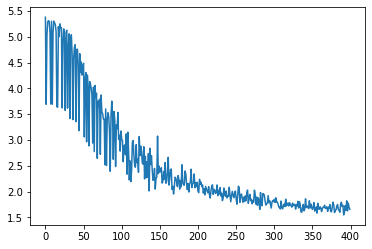

finetuning goes brrr: 400it [03:19,  2.01it/s, loss=1.66]


In [22]:
#@markdown You can unfreeze or freeze more parametrs, but it can 
model = freeze(model = model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False)#freeze params to 

train(model, args, train_dataloader)

In [23]:
#load model 
model_path = os.path.join('./'+args.save_path,f"{args.model_name}_dalle_last.pt")
model = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)
model.load_state_dict(torch.load(model_path)) 
print(f'Loaded from {model_path}')
vae = get_vae().to(device)

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.
Loaded from ./checkpoints/apes__dalle_last.pt
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

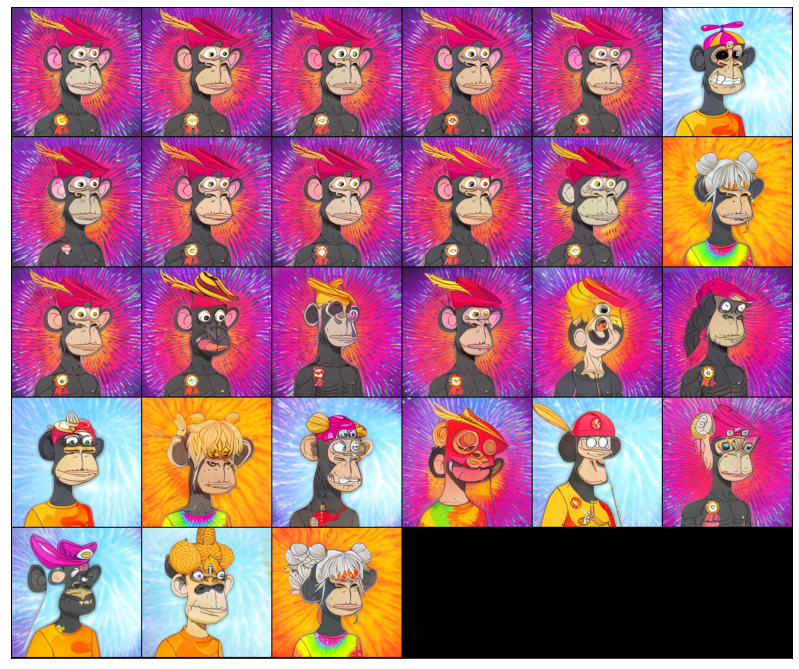

In [28]:
pil_images = []
scores = []
text = 'обезьяна с тигровыми полосками в шляпе с крыльями и клавиатурой на фоне радужных водоворотов'

for top_k, top_p, images_num in [(2048, 0.995, 27)]:
    _pil_images, _scores = generate_images(text, tokenizer, model, vae, top_k=top_k, images_num=images_num, top_p=top_p)
    pil_images += _pil_images
    scores += _scores
show(pil_images, 9)

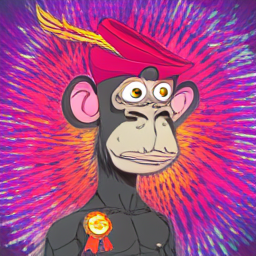

In [31]:
pil_images[0]

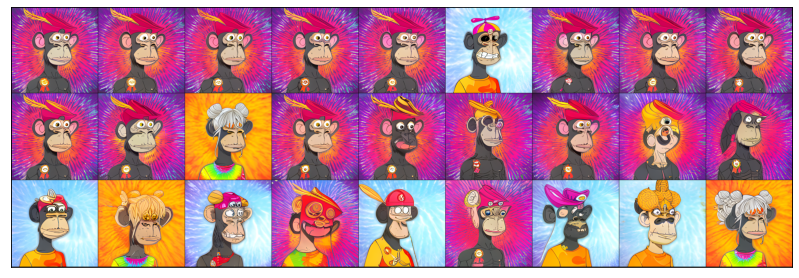

In [32]:
sr_images = super_resolution(pil_images, realesrgan)
show(sr_images, 9)

In [33]:
sr_images[0].save("new_ape_01.jpg")

In [34]:
sr_images[5].save("new_ape_02.jpg")

In [35]:
sr_images[11].save("new_ape_03.jpg")

In [36]:
sr_images[18].save("new_ape_04.jpg")

In [37]:
sr_images[21].save("new_ape_05.jpg")

In [38]:
sr_images[22].save("new_ape_06.jpg")

In [39]:
sr_images[23].save("new_ape_07.jpg")

In [40]:
sr_images[24].save("new_ape_08.jpg")

In [41]:
sr_images[25].save("new_ape_09.jpg")

In [42]:
sr_images[26].save("new_ape_10.jpg")